In [1]:
DATA_PATH = "data/11-785hw2p2-s20/"
MODEL_PATH = "model/"
SUBMISSION_PATH = "submission/"

In [2]:
batch_size = 256
num_workers = 4

In [26]:
import os
import numpy as np
import time

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import sys
import pandas as pd
from scipy import spatial

In [4]:
data_transforms = torchvision.transforms.Compose([
        #torchvision.transforms.ToPILImage(),
        #torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH+'train_data/medium', transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)
dev_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH+'validation_classification/medium', 
                                               transform=data_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=num_workers,pin_memory=False)

In [6]:
len(train_dataset), len(train_dataset.classes)

(822155, 2300)

In [7]:
len(dev_dataset), len(dev_dataset.classes)

(4600, 2300)

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

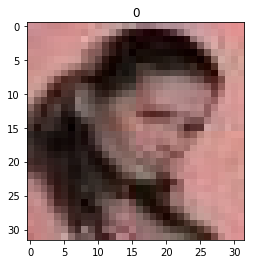

In [10]:
inputs, classes = train_dataset[0]
out = torchvision.utils.make_grid(inputs)
imshow(out, title=idx_to_class[classes])

In [11]:
class VerificationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with picture pairs
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.verification_frame = pd.read_csv(csv_file, sep = " ", header = None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.verification_frame.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img1_name = os.path.join(self.root_dir,
                                self.verification_frame.iloc[idx, 0])
        img2_name = os.path.join(self.root_dir,
                                self.verification_frame.iloc[idx, 1])
        
        to_pil = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])
        image1 = to_pil(plt.imread(img1_name))
        image2 = to_pil(plt.imread(img2_name))
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if len(self.verification_frame.columns) == 3:
            target = self.verification_frame.iloc[idx, 2].astype('int32')
            return image1, image2, target
        else:
            return image1, image2

In [12]:
verification_dataset = VerificationDataset(DATA_PATH+"validation_trials_verification.txt",DATA_PATH+"validation_verification",data_transforms)
verification_dataloader = DataLoader(verification_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)

In [13]:
print (verification_dataset[0][0].shape)
print (verification_dataset[0][2])
print (len(verification_dataset))

torch.Size([3, 32, 32])
0
100000


In [14]:
#The following piece of code for Center Loss has been pulled and 
#modified based on the code from the GitHub Repo: https://github.com/KaiyangZhou/pytorch-center-loss
#Reference: Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

class CenterLoss(nn.Module):
    """
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, feat_dim):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

In [15]:
# refactor from recitation 6 and https://github.com/hysts/pytorch_resnet/blob/master/resnet.py

class BottleneckBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.expansion = 4
        bottleneck_channels = out_channels // self.expansion
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv1 = nn.Conv2d(in_channels,bottleneck_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = nn.Conv2d(bottleneck_channels,bottleneck_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = nn.Conv2d(bottleneck_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,padding=0,bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)
        return y
  

In [16]:
# refactor from recitation 6 and https://github.com/hysts/pytorch_resnet/blob/master/resnet.py

class Network(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(Network, self).__init__()

        self.layers = []

        self.layers.append(nn.Conv2d(in_channels=num_feats, out_channels=64, kernel_size=3, padding = 1, stride=1, bias=False))
        self.layers.append(nn.BatchNorm2d(64))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(3, stride=2, padding=1))

        in_channels = 64
        for out_channels, block_count in zip([128,256,512,1024],[2,3,5,3]):
            for i in range(block_count):
                self.layers.append(BottleneckBlock(in_channels, out_channels))
                in_channels = out_channels

        self.layers.append(nn.AdaptiveAvgPool2d((1,1)))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(1024, 4096))
        self.layers.append(nn.BatchNorm1d(4096))
        self.layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*self.layers)
        self.linear_label = nn.Linear(4096, num_classes, bias=False)
    
    def forward(self, x, evalMode=False):
        features = self.layers(x)
          
        label_output = self.linear_label(features)
        #label_output = label_output/torch.norm(self.linear_label.weight, dim=1)
        
        return features, label_output

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [60]:
feat_dim = 4096
model = Network(3, len(train_dataset.classes))
#model.apply(init_weights)
model.load_state_dict(torch.load(MODEL_PATH+'model_1583478712.pt'))
model.cuda()
print (model)

Network(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): BottleneckBlock(
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

In [61]:
criterion_label = nn.CrossEntropyLoss()
criterion_closs = CenterLoss(len(train_dataset.classes), feat_dim)

optimizer_label = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler_label = torch.optim.lr_scheduler.StepLR(optimizer_label, step_size=1, gamma=0.1)
optimizer_closs = torch.optim.SGD(criterion_closs.parameters(), lr=0.5)

closs_weight = 0.0001
numEpochs = 5

In [62]:
def train_closs(model, data_loader, classification_test_loader, verification_test_loader, task='Verification'):
    best_model = None
    lowest_val_acc = None
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in tqdm(enumerate(data_loader)):
            feats, labels = feats.cuda(), labels.cuda()
            
            optimizer_label.zero_grad()
            optimizer_closs.zero_grad()
            
            feature, outputs = model(feats)

            l_loss = criterion_label(outputs, labels.long())
            c_loss = criterion_closs(feature, labels.long())
            loss = l_loss + closs_weight * c_loss
            
            loss.backward()
            
            optimizer_label.step()
            # by doing so, weight_cent would not impact on the learning of centers
            for param in criterion_closs.parameters():
                param.grad.data *= (1. / closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/100))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
            
        scheduler_label.step()
        #scheduler_closs.step()
            
        val_loss, val_acc = test_classify_closs(model, classification_test_loader)
        print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(val_loss, val_acc))
        val_auc = test_verify(model, verification_test_loader)
        print('Val Auc: {:.4f}'.format(val_auc))
        torch.save(model.state_dict(), MODEL_PATH+'Checkpoint/closs_model_%d_%d.pt'%(int(time.time()), epoch+1))
        if ((best_model == None) or (val_acc < lowest_acc)):
            best_model = model
            lowest_acc = val_acc
    torch.save(best_model.state_dict(), MODEL_PATH+'closs_model_%d.pt'%int(time.time()))
    return best_model


def test_classify_closs(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0
    with torch.no_grad():
        for batch_num, (feats, labels) in tqdm(enumerate(test_loader)):
            feats, labels = feats.cuda(), labels.cuda()
            feature, outputs = model(feats)

            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)

            l_loss = criterion_label(outputs, labels.long())
            c_loss = criterion_closs(feature, labels.long())
            loss = l_loss + closs_weight * c_loss

            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])
            del feats
            del labels
    return np.mean(test_loss), accuracy/total

def get_auc(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    return auc

def test_verify(model, test_loader):
    model.eval()
    preds = torch.FloatTensor().cuda()
    actuals = torch.FloatTensor().cuda()
    with torch.no_grad():
        for batch_num, (feats1, feats2, labels) in tqdm(enumerate(test_loader)):
            feats1, feats2, labels = feats1.cuda(), feats2.cuda(), labels.cuda()
            feature1, _ = model(feats1)
            feature2, _ = model(feats2)
            predicted = F.cosine_similarity(feature1, feature2)
            preds = torch.cat((preds, predicted), dim=0)
            actuals = torch.cat((actuals, labels.float()), dim=0)
            del feats1
            del feats2
            del labels
            del feature1
            del feature2
            del predicted
    preds = preds.cpu().numpy()
    actuals = actuals.cpu().numpy()
    return get_auc(actuals, preds)


In [63]:
train_closs(model, train_dataloader, dev_dataloader, verification_dataloader)

Epoch: 1	Batch: 100	Avg-Loss: 1.5715
Epoch: 1	Batch: 200	Avg-Loss: 1.5535
Epoch: 1	Batch: 300	Avg-Loss: 1.5535
Epoch: 1	Batch: 400	Avg-Loss: 1.5424
Epoch: 1	Batch: 500	Avg-Loss: 1.5170
Epoch: 1	Batch: 600	Avg-Loss: 1.4692
Epoch: 1	Batch: 700	Avg-Loss: 1.4826
Epoch: 1	Batch: 800	Avg-Loss: 1.4435
Epoch: 1	Batch: 900	Avg-Loss: 1.4381
Epoch: 1	Batch: 1000	Avg-Loss: 1.4179
Epoch: 1	Batch: 1100	Avg-Loss: 1.4059
Epoch: 1	Batch: 1200	Avg-Loss: 1.3954
Epoch: 1	Batch: 1300	Avg-Loss: 1.3720
Epoch: 1	Batch: 1400	Avg-Loss: 1.3806
Epoch: 1	Batch: 1500	Avg-Loss: 1.3648
Epoch: 1	Batch: 1600	Avg-Loss: 1.3664
Epoch: 1	Batch: 1700	Avg-Loss: 1.3530
Epoch: 1	Batch: 1800	Avg-Loss: 1.3478
Epoch: 1	Batch: 1900	Avg-Loss: 1.3376
Epoch: 1	Batch: 2000	Avg-Loss: 1.3416
Epoch: 1	Batch: 2100	Avg-Loss: 1.3359
Epoch: 1	Batch: 2200	Avg-Loss: 1.3223
Epoch: 1	Batch: 2300	Avg-Loss: 1.3270
Epoch: 1	Batch: 2400	Avg-Loss: 1.3184
Epoch: 1	Batch: 2500	Avg-Loss: 1.2956
Epoch: 1	Batch: 2600	Avg-Loss: 1.3200
Epoch: 1	Batch: 2700	


Val Loss: 1.7999	Val Accuracy: 0.6480



Val Auc: 0.9217


Epoch: 2	Batch: 100	Avg-Loss: 1.0686
Epoch: 2	Batch: 200	Avg-Loss: 0.9968
Epoch: 2	Batch: 300	Avg-Loss: 0.9630
Epoch: 2	Batch: 400	Avg-Loss: 0.9542
Epoch: 2	Batch: 500	Avg-Loss: 0.9309
Epoch: 2	Batch: 600	Avg-Loss: 0.9109
Epoch: 2	Batch: 700	Avg-Loss: 0.9101
Epoch: 2	Batch: 800	Avg-Loss: 0.8830
Epoch: 2	Batch: 900	Avg-Loss: 0.9186
Epoch: 2	Batch: 1000	Avg-Loss: 0.8866
Epoch: 2	Batch: 1100	Avg-Loss: 0.8879
Epoch: 2	Batch: 1200	Avg-Loss: 0.8735
Epoch: 2	Batch: 1300	Avg-Loss: 0.8767
Epoch: 2	Batch: 1400	Avg-Loss: 0.8510
Epoch: 2	Batch: 1500	Avg-Loss: 0.8823
Epoch: 2	Batch: 1600	Avg-Loss: 0.8642
Epoch: 2	Batch: 1700	Avg-Loss: 0.8525
Epoch: 2	Batch: 1800	Avg-Loss: 0.8569
Epoch: 2	Batch: 1900	Avg-Loss: 0.8540
Epoch: 2	Batch: 2000	Avg-Loss: 0.8312
Epoch: 2	Batch: 2100	Avg-Loss: 0.8424
Epoch: 2	Batch: 2200	Avg-Loss: 0.8400
Epoch: 2	Batch: 2300	Avg-Loss: 0.8211
Epoch: 2	Batch: 2400	Avg-Loss: 0.8440
Epoch: 2	Batch: 2500	Avg-Loss: 0.8504
Epoch: 2	Batch: 2600	Avg-Loss: 0.8469
Epoch: 2	Batch: 2700	


Val Loss: 1.2256	Val Accuracy: 0.7598



Val Auc: 0.9342


Epoch: 3	Batch: 100	Avg-Loss: 0.7124
Epoch: 3	Batch: 200	Avg-Loss: 0.6978
Epoch: 3	Batch: 300	Avg-Loss: 0.6982
Epoch: 3	Batch: 400	Avg-Loss: 0.6938
Epoch: 3	Batch: 500	Avg-Loss: 0.6744
Epoch: 3	Batch: 600	Avg-Loss: 0.6653
Epoch: 3	Batch: 700	Avg-Loss: 0.6767
Epoch: 3	Batch: 800	Avg-Loss: 0.6769
Epoch: 3	Batch: 900	Avg-Loss: 0.6717
Epoch: 3	Batch: 1000	Avg-Loss: 0.6793
Epoch: 3	Batch: 1100	Avg-Loss: 0.6677
Epoch: 3	Batch: 1200	Avg-Loss: 0.6784
Epoch: 3	Batch: 1300	Avg-Loss: 0.6944
Epoch: 3	Batch: 1400	Avg-Loss: 0.6868
Epoch: 3	Batch: 1500	Avg-Loss: 0.6733
Epoch: 3	Batch: 1600	Avg-Loss: 0.6688
Epoch: 3	Batch: 1700	Avg-Loss: 0.6686
Epoch: 3	Batch: 1800	Avg-Loss: 0.6853
Epoch: 3	Batch: 1900	Avg-Loss: 0.6829
Epoch: 3	Batch: 2000	Avg-Loss: 0.6841
Epoch: 3	Batch: 2100	Avg-Loss: 0.6697
Epoch: 3	Batch: 2200	Avg-Loss: 0.6740
Epoch: 3	Batch: 2300	Avg-Loss: 0.6770
Epoch: 3	Batch: 2400	Avg-Loss: 0.6617
Epoch: 3	Batch: 2500	Avg-Loss: 0.6729
Epoch: 3	Batch: 2600	Avg-Loss: 0.6833
Epoch: 3	Batch: 2700	


Val Loss: 1.1114	Val Accuracy: 0.7796



Val Auc: 0.9371


Epoch: 4	Batch: 100	Avg-Loss: 0.6554
Epoch: 4	Batch: 200	Avg-Loss: 0.6555


KeyboardInterrupt: 

In [64]:
torch.save(model.state_dict(), MODEL_PATH+'closs_model_%d.pt'%int(time.time()))

In [65]:
class TestImageFolder(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.jpg'):
                    self.file_list.append(file)
        self.file_list.sort()
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.file_list[idx])
        to_pil = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])
        image = to_pil(plt.imread(img_name))
        if self.transform:
            image = self.transform(image)
        return image

In [66]:
test_dataset = TestImageFolder(DATA_PATH+'test_classification/medium', 
                                               transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=num_workers,pin_memory=True)

In [67]:
len(test_dataset)

4600

In [68]:
print (test_dataset.file_list[0])
print (test_dataset[0][1].shape)

5000.jpg
torch.Size([32, 32])


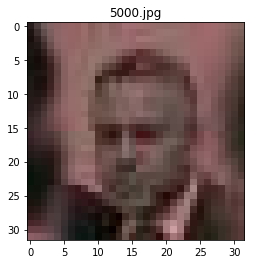

In [69]:
inputs = test_dataset[0]
out = torchvision.utils.make_grid(inputs)
imshow(out,title=test_dataset.file_list[0])

In [70]:
model.eval()

image_names = test_dataset.file_list
test_preds = torch.LongTensor().cuda()
with torch.no_grad():
    for batch_num, feats in tqdm(enumerate(test_dataloader)):
        feats = feats.cuda()
        outputs = model(feats)[1]

        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        test_preds = torch.cat((test_preds, pred_labels), dim=0)

        del feats
        del pred_labels
    
out_df = pd.DataFrame()
out_df['Id'] = image_names
out_df['Category'] = test_preds.cpu().numpy()
out_df['Category'] = out_df['Category'].map(idx_to_class)
out_df.head()

,Id,Category
0,5000.jpg,1631
1,5001.jpg,908
2,5002.jpg,189
3,5003.jpg,1359
4,5004.jpg,1782


In [71]:
file_name = SUBMISSION_PATH+"submission_%d.csv"%int(time.time())
out_df.to_csv(file_name,index=False)

In [72]:
verification_test_dataset = VerificationDataset(DATA_PATH+"test_trials_verification_student.txt",DATA_PATH+"test_verification",data_transforms)
verification_test_dataloader = DataLoader(verification_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)


In [73]:
len(verification_test_dataset)

899965

In [75]:
model.eval()
preds = torch.FloatTensor().cuda()
with torch.no_grad():
    for batch_num, (feats1, feats2) in tqdm(enumerate(verification_test_dataloader)):
        feats1, feats2 = feats1.cuda(), feats2.cuda()
        feature1, _ = model(feats1)
        feature2, _ = model(feats2)
        predicted = F.cosine_similarity(feature1, feature2)
        preds = torch.cat((preds, predicted), dim=0)
        del feats1
        del feats2
        del feature1
        del feature2
        del predicted

preds = preds.cpu().numpy()
out_df = pd.DataFrame()
trial_id = pd.read_csv(DATA_PATH+"test_trials_verification_student.txt", header = None)[0]

out_df['trial'] = trial_id
out_df['score'] = preds
out_df.head()


,trial,score
0,262615.jpg 207587.jpg,0.274809
1,120800.jpg 162540.jpg,0.298063
2,200386.jpg 117646.jpg,0.317300
3,268346.jpg 264478.jpg,0.246046
4,171295.jpg 143107.jpg,0.288800


In [76]:
file_name = SUBMISSION_PATH+"submission_verification_%d.csv"%int(time.time())
out_df.to_csv(file_name,index=False)